In [1]:
import numpy as np
from numba import njit

In [2]:
# Model parameters
median = 1.75/1000
γ = 0.018
τ = median * γ
δ = 0.01
η = 0.032
ξ_m = 0.00256

μ_2 = 1.
ρ = 0.5
σ_2 = np.sqrt((0.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} - \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} + \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [3]:
@njit(parallel=True, cache=True)
def solver(ψ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ):
    n_b = len(b_grid)
    n_z = len(z_grid)
    Δ_b = b_grid[1] - b_grid[0]
    Δ_z = z_grid[1] - z_grid[0]
    LHS = np.zeros((n_b*n_z, n_b*n_z))
    RHS = np.zeros(n_b*n_z)
    for j in range(n_z):
        for i in range(n_b):
            idx = j*n_b + i
            idx_bp1 = idx + 1
            idx_bm1 = idx - 1
            idx_zp1 = (j+1)*n_b + i
            idx_zp2 = (j+2)*n_b + i
            idx_zm1 = (j-1)*n_b + i
            idx_zm2 = (j-2)*n_b + i
            ψ = ψ_grid[idx]
            z = z_grid[j]
            b = b_grid[i]
            LHS[idx, idx] += - 1./ϵ
            if i == 0:
                dψdb = (ψ_grid[idx_bp1]-ψ_grid[idx])/Δ_b
                e = b*δ*η/(b*τ*z+ℓ)
                LHS[idx, idx] += δ*b/Δ_b
                LHS[idx, idx_bp1] += -δ*b/Δ_b
            elif i == n_b-1:
                dψdb = (ψ_grid[idx]-ψ_grid[idx_bm1])/Δ_b
                e = b*δ*η/(b*τ*z+ℓ)
                LHS[idx, idx] += -δ*b/Δ_b
                LHS[idx, idx_bm1] += δ*b/Δ_b
            else:
                dψdb = (ψ_grid[idx_bp1]-ψ_grid[idx_bm1])/(2*Δ_b)
                e = b*δ*η/(b*τ*z+ℓ)
                LHS[idx, idx] += -δ*b/Δ_b
                LHS[idx, idx_bm1] += δ*b/Δ_b
            temp_2 = z*σ_2**2/2
            if j == 0:
                dψdz = (ψ_grid[idx_zp1]-ψ_grid[idx])/Δ_z
                h = -dψdz*np.sqrt(z)*σ_2/(b*ξ_m)
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += -temp_1/Δ_z + temp_2/(Δ_z**2)  
                LHS[idx, idx_zp1] += temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp2] += temp_2/(Δ_z**2)
            elif j == n_z-1:
                dψdz = (ψ_grid[idx]-ψ_grid[idx_zm1])/Δ_z
                h = -dψdz*np.sqrt(z)*σ_2/(b*ξ_m)
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += temp_1/Δ_z + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zm2] += temp_2/(Δ_z**2)            
            else:
                dψdz = (ψ_grid[idx_zp1]-ψ_grid[idx_zm1])/(2*Δ_z)
                h = -dψdz*np.sqrt(z)*σ_2/(b*ξ_m)
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += temp_1/Δ_z*(-1.*(temp_1>0)+(temp_1<0)) - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp1] += temp_1/Δ_z*(temp_1>0) + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z*(temp_1<0) + temp_2/(Δ_z**2)
            RHS[idx] = -(1./ϵ*ψ + b*(δ*η*np.log(e) - τ*z*e + ξ_m*h**2/2) - ℓ*e)
    ψ_grid = np.linalg.solve(LHS, RHS)
    return ψ_grid


@njit
def false_transient(ψ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9):
    error = 1.
    count = 0
    while error > tol and count < max_iter:
        ψ_grid_old = ψ_grid.copy()
        ψ_grid = solver(ψ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)
        error = np.max(np.abs(ψ_grid_old-ψ_grid))/ϵ
        count += 1
        print('Iteration:', count, ', error:', error)
    return ψ_grid

In [10]:
ϵ = 0.5
b_max = 1.0
z_max = 2.0
n_b = 200
n_z = 20
b_grid = np.linspace(1e-2, 1., n_b)
z_grid = np.linspace(1e-5, z_max, n_z)
ψ_grid = np.zeros(n_b*n_z) # initial guess

In [ ]:
ℓ = 1e-5
ψ_grid = false_transient(ψ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9)   

Iteration: 1 , error: 0.0006480569840478794
Iteration: 2 , error: 0.000557935208925366
Iteration: 3 , error: 0.0004967632256033178
Iteration: 4 , error: 0.00045333784991026765
Iteration: 5 , error: 0.00042144357362185886
Iteration: 6 , error: 0.00039738663408532245
Iteration: 7 , error: 0.00037884358900003
Iteration: 8 , error: 0.00036428395553239016
Iteration: 9 , error: 0.000352661515187059
Iteration: 10 , error: 0.0003432395912059804
Iteration: 11 , error: 0.0003354870741982749
Iteration: 12 , error: 0.0003290137810524115
Iteration: 13 , error: 0.00032352871239553146
Iteration: 14 , error: 0.0003188122009435872
Iteration: 15 , error: 0.00031469680109702265
Iteration: 16 , error: 0.0003110538608590632
Iteration: 17 , error: 0.0003077838948087998
Iteration: 18 , error: 0.0003048095641565987
Iteration: 19 , error: 0.00030207048432248033
Iteration: 20 , error: 0.00029951933795549935
Iteration: 21 , error: 0.0002971189357383417
Iteration: 22 , error: 0.0002948399749894987
Iteration: 23 ,

Iteration: 179 , error: 9.824951188902586e-05
Iteration: 180 , error: 9.747586127926977e-05
Iteration: 181 , error: 9.670670529283304e-05
Iteration: 182 , error: 9.59420218843432e-05
Iteration: 183 , error: 9.518178911045727e-05
Iteration: 184 , error: 9.44259851291887e-05
Iteration: 185 , error: 9.367458819933838e-05
Iteration: 186 , error: 9.29275766802587e-05
Iteration: 187 , error: 9.218492903099312e-05
Iteration: 188 , error: 9.144662381010277e-05
Iteration: 189 , error: 9.071263967470183e-05
Iteration: 190 , error: 8.998295538058948e-05
Iteration: 191 , error: 8.925754978118816e-05
Iteration: 192 , error: 8.853640182728689e-05
Iteration: 193 , error: 8.781949056655552e-05
Iteration: 194 , error: 8.710679514294106e-05
Iteration: 195 , error: 8.639829479630684e-05
Iteration: 196 , error: 8.569396886187741e-05
Iteration: 197 , error: 8.499379676974589e-05
Iteration: 198 , error: 8.429775804453393e-05
Iteration: 199 , error: 8.36058323043995e-05
Iteration: 200 , error: 8.291799926143

Iteration: 357 , error: 1.4464162947314119e-05
Iteration: 358 , error: 1.422002926281668e-05
Iteration: 359 , error: 1.39776916244852e-05
Iteration: 360 , error: 1.3737140144860771e-05
Iteration: 361 , error: 1.3498364980539523e-05
Iteration: 362 , error: 1.3261356332734675e-05
Iteration: 363 , error: 1.3026104446443865e-05
Iteration: 364 , error: 1.2792599610657318e-05
Iteration: 365 , error: 1.2560832157997026e-05
Iteration: 366 , error: 1.233079246455715e-05
Iteration: 367 , error: 1.2102470949737487e-05
Iteration: 368 , error: 1.187585807632674e-05
Iteration: 369 , error: 1.1650944349725356e-05
Iteration: 370 , error: 1.1427720318493706e-05
Iteration: 371 , error: 1.1206176573658189e-05
Iteration: 372 , error: 1.0986303748634907e-05
Iteration: 373 , error: 1.0768092519312933e-05
Iteration: 374 , error: 1.0562632184103228e-05
Iteration: 375 , error: 1.0561691716783105e-05
Iteration: 376 , error: 1.0561434099728463e-05
Iteration: 377 , error: 1.0560930029182743e-05
Iteration: 378 , e

In [ ]:
# log_ell_grid = np.linspace(log_ell_min, log_ell_max, grid_size)
log_ell_grid = np.linspace(-20, -5, 100)
ψ_grid_list = []
for i in range(20):
#     ψ_grid = np.load('res_guess.npy') # initial guess
    ψ_grid = np.zeros(n_b*n_z) # initial guess
    log_ell = log_ell_grid[i]
    ℓ = np.exp(log_ell)
    print(i)
    ψ_grid = false_transient(ψ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9)   
    np.save('res_'+str(i), ψ_grid)

In [11]:
ψ_grid = np.load('res_0.npy')

In [12]:
ψ_grid = ψ_grid.reshape((n_b, n_z), order='F')

In [14]:
ψ_grid[-1, :]

array([0.0442123 , 0.04357727, 0.04338886, 0.04325399, 0.04314068,
       0.04304073, 0.04295039, 0.04286748, 0.04279062, 0.04271885,
       0.04265157, 0.04258823, 0.04252807, 0.04247062, 0.04241554,
       0.04236258, 0.04231154, 0.04226224, 0.04221458, 0.04216846])

In [ ]:
# Compute e_grid conditioned on z2
z_loc = 10
z = z_grid[z_loc]
Δ_r = r_grid[1] - r_grid[0]
dϕdr = np.zeros_like(r_grid) 
for i in range(n_r):
    if i == 0:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i, z_loc])/Δ_r
    elif i == n_r-1:
        dϕdr[i] = (ϕ[i, z_loc] - ϕ[i-1, z_loc])/Δ_r
    else:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i-1, z_loc])/(2*Δ_r)
e_grid = δ*η/(τ*z + dϕdr)

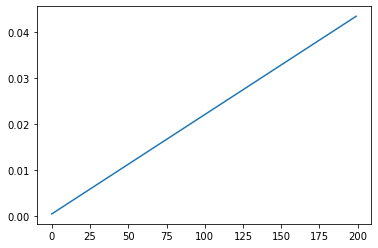

In [22]:
import matplotlib.pyplot as plt
# plt.plot(e_grid)
# plt.ylim(0, 20)
plt.plot(ψ_grid[:, 2])

In [ ]:
plt.plot(ϕ[:,0])
plt.ylim(0, 0.05)

In [ ]:
ϕ[:, 10]

In [ ]:
import pickle

In [ ]:
with open('solu_modified_40200_0900', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
ϕ_suri = b['phi']

In [ ]:
plt.plot(ϕ_suri[0, :])
plt.ylim(0, 0.05)

In [ ]:
ϕ_suri_new = ϕ_suri.T.reshape(-1, order='F')

In [ ]:
res = solver(ϕ_suri_new, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)

In [ ]:
np.abs(np.max((res - ϕ_suri_new)/ϵ))